In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from osgeo import gdal
import pandas as pd
from affine import Affine
from pyproj import Proj, transform, Transformer
import os
import gdal
from astropy.table import Table, Column

from Temp_linear import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
def get_Coordinates(GeoTiff_name):

    # Read raster
    with rasterio.open(GeoTiff_name) as r:
        T0 = r.transform  # upper-left pixel corner affine transform
        A = r.read()  # pixel values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: T1 * (c, r)

    # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

      
    transformer =  Transformer.from_proj(
        'EPSG:4326',
        '+proj=longlat +datum=WGS84 +no_defs +type=crs',
        always_xy=True,
        skip_equivalent=True)
    
    LON, LAT = transformer.transform(eastings, northings)
    return LON, LAT


In [4]:
def genParamCode(param):
    
    if param=='coastDist':
        return 'coastDistM'
    elif param=='rf':
        return 'meanAnn'
    else:
        return param

In [5]:
def genTiffName(param='dem', iCode='bi'):
    
    if param=='dem_250':
        param = 'dem'
    
    pCODE = genParamCode(param)
    TiffName = r'./geoTiffs_250m/'+param+'/'+iCode+'_'+pCODE+'_250m.tif'    
    
    return TiffName

In [6]:
def getDataArray(param='dem_250', iCode='bi', getMask=False):
    
    TiffName = genTiffName(param=param, iCode=iCode)
    raster_img = rasterio.open(TiffName)

    myarray = raster_img.read(1)
    msk = raster_img.read_masks(1)

    msk[msk>0] = 1
    dataArray = myarray * msk
    
    dataArray[msk==0] = 0
    
    if getMask:
        return msk, myarray.shape    # 0:reject  >0:accept

    return dataArray

In [7]:
def get_island_grid(iCode, params):

    TiffName = genTiffName(iCode=iCode)
    LON, LAT = get_Coordinates(TiffName)
    LON = LON.reshape(-1)
    LAT = LAT.reshape(-1)

    myDict = {'LON':LON, 'LAT':LAT}

    for param in params:

        myDict[param] = getDataArray(iCode=iCode, param=param).reshape(-1)


    island_df = pd.DataFrame.from_dict(myDict)
    
    mask, shape = getDataArray(iCode=iCode, getMask=True)

    return island_df, mask.reshape(-1), shape

In [8]:
def G_islandName(iCode):
    
    if iCode=='bi':
        return "Big Island"
    elif iCode=='oa':
        return "Oahu"
    elif iCode=='mn':
        return "Maui+"
    elif iCode=='ka':
        return "Kauai"
    else:
        return iCode

In [9]:
iCode = 'bi'
mode = 'max'
params = ["dem_250"] # , "rf", "lai", "tpi", "rf", "albedo"]
date_str = '2005-08-10'

threshold = 2.5
inversion = 2150   # meter
mixHighAlt = 2150   # meter

predictors = "t" + mode + "_predictors.csv"
temperature = "T" + mode + "_QC.csv"
rain = "2_Partial_Fill_Daily_RF_mm_1990_2020.csv"
inputs = [predictors, temperature, rain]

island_df, mask, shape = get_island_grid(iCode, params)

param_List = ["Island", "LON", "LAT"] + params

df_station, rf_station, pr_station, ISLAND_code = Data_prep(iCode.upper(), 
                                                            mode, 
                                                            inputFileList=inputs,
                                                            mixHighAlt=mixHighAlt)
# df_station, rf_station, pr_station, ISLAND_code = Data_prep(['MA', 'KO', 'MO', 'LA', 'BI'], mode, codeIsList=True)

df_date = prep_Data(date_str, df_station, rf_station, pr_station)


MODEL = myModel(inversion=inversion)
theta, cov, X, y = makeModel(df_date, param_List, MODEL, threshold=threshold)

In [10]:
X.shape

(30, 4)

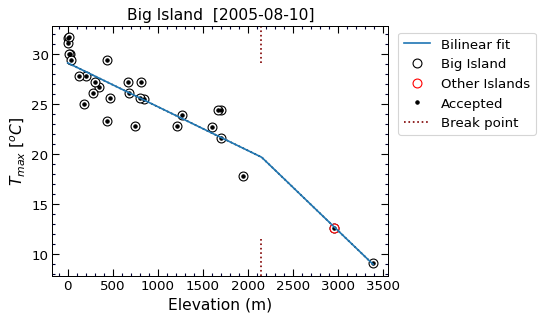

In [12]:
fig = pyplot.figure(figsize=(7,4), dpi=80)
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.1, right=0.7)
ax = fig.add_subplot(111)

N = int(np.round(np.max(X[:,3])))
_, n_params = X.shape
u = np.zeros((N,n_params))
u[:,3] = np.arange(N)
v = MODEL(u[:,3:], *theta)

ax.plot(u[:,3], v, 'k:')

df_date = df_date[["T"] + param_List].dropna()
X = df_date[param_List].values
y = df_date['T'].values
ax.plot(X[:,3], y, 'ko', mfc='white', ms=8)

df_BI = df_date[~df_date.Island.isin(ISLAND_code)]
X0 = df_BI[param_List].values
y0 = df_BI['T'].values
ax.plot(X0[:,3], y0, 'ro', mfc='white', ms=8)


indx = removeOutlier(X, y, threshold=threshold) # get the indices of acceptable data points
X1 = X[indx]
y1 = y[indx]
ax.plot(X1[:,3], y1, 'k.', mfc='k')


N = int(np.round(np.max(X[:,3])))
u = np.zeros((N,n_params))
u[:,3] = np.arange(N)
v = MODEL(u[:,3:], *theta)
ax.plot(u[:,3], v, label='Bilinear fit')

ax.set_xlabel("Elevation (m)", fontsize=14)
ax.set_ylabel(r"$T_{"+mode+"} \/\/[^oC]$", fontsize=14)
ax.set_title(G_islandName(iCode)+"  ["+date_str+"]", fontsize=14)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.plot([-1000], [-1000], 'ko', mfc='white', ms=8, label=G_islandName(iCode))
ax.plot([-1000], [-1000], 'ro', mfc='white', ms=8, label='Other Islands')
ax.plot([-1000], [-1000], 'k.', mfc='k', label='Accepted')


# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
yl2 = 0.15*ylim[0]+0.85*ylim[1]
yl1 = 0.*ylim[0]+1*ylim[1]
ax.plot([inversion, inversion],[yl1, yl2], ':', color='maroon', label='Break point')
yl2 = 0.85*ylim[0]+0.15*ylim[1]
yl1 = 1.*ylim[0]+0*ylim[1]
ax.plot([inversion, inversion],[yl1, yl2], ':', color='maroon')

set_axes(ax, xlim=xlim, ylim=ylim, fontsize=12)

ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)
fig.savefig('test1.png', dpi=200) 

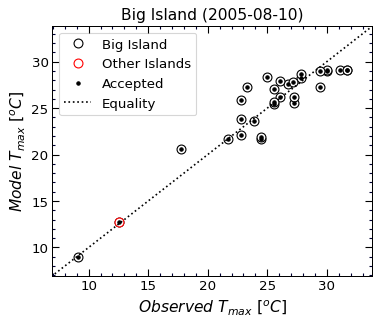

In [13]:
fig = pyplot.figure(figsize=(5,4), dpi=80)
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)

ax.plot(y, MODEL(X[:,3:], *theta), 'ko', mfc='white', ms=8, label=G_islandName(iCode))
ax.plot(y0, MODEL(X0[:,3:], *theta), 'ro', mfc='white', ms=8, label='Other Islands')
ax.plot(y1, MODEL(X1[:,3:], *theta), 'k.', mfc='k', label='Accepted')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

lim1 = np.min([xlim[0],ylim[0]])-1
lim2 = np.max([xlim[1],ylim[1]])+1

ax.plot([-10,35], [-10,35], 'k:', label='Equality')

ax.set_xlabel(r"$Observed \/\/ T_{"+mode+"} \/\/[^oC]$", fontsize=14)
ax.set_ylabel(r"$Model \/\/ T_{"+mode+"} \/\/[^oC]$", fontsize=14)
ax.set_title(G_islandName(iCode)+" ("+date_str+")", fontsize=14)

set_axes(ax, xlim=(lim1, lim2), ylim=(lim1, lim2), fontsize=12)
ax.legend(loc='upper left', fontsize=12)

fig.savefig('test1.png', dpi=200) 

In [14]:
df_date['flag'] = False
temp = df_date.flag.values
temp[indx] = True
df_date['flag'] = temp
df_date['T_model'] = MODEL(X[:,3:], *theta)

df_output = df_date[["T"]+param_List+["flag", "T_model"]]
df_output_ = df_output.reset_index()
df_output_.to_csv('test.csv', sep=',', index=False)


table   = np.genfromtxt('test.csv' , delimiter=',', 
                        filling_values=-1000000, names=True, dtype=None, encoding=None)

colnames = table.dtype.names

## table is a structured array
myTable = {}
for name in table.dtype.names:
    myTable[name] = table[name]
table = myTable
## table is now a dictionary

myTable = Table()

for key in colnames:
    if key in ["SKN", "Island", "flag"]:
        myTable.add_column(Column(data=table[key], name=key))
    elif key in ['LON', "LAT"]:
        myTable.add_column(Column(data=table[key], name=key, format='%0.4f'))      
    else:
        myTable.add_column(Column(data=table[key], name=key, format='%0.3f'))

## to be used on EDD
myTable.write('test.csv', format='ascii.fixed_width',delimiter='|', bookend=False, overwrite=True)

with open("test.csv", "r") as File:
    reader = File.read()

In [15]:
n_data, n_param = X1[:,3:].shape
MAE, RMSE, R2, AIC, AICc, BIC = metrics(y1, MODEL(X1[:,3:], *theta), n_param=n_param, n_data=n_data, verbose=False)


In [16]:
with open('test.csv', 'w') as File: 
    
    cols = df_output.columns

    s = " Equation: T = B0 + B1*"+cols[4]+" + B2*"+cols[4]+"[z>"+str(inversion)+"]"

    for t in range(1, n_params-2):
        s += " + B"+str(t+2)+"*"+cols[t+4]
    
    File.write(' ----------------------------------------------------')
    File.write('\n'+s)

    File.write("\n\n B: "+str(theta))
    File.write("\n Covariance:\n "+str(cov))
    
    File.write('\n\n MAE: %.2f' % MAE + '\n RMSE: %.2f' % RMSE + '\n R^2: %.2f' % R2)
    File.write('\n AIC: %.2f' % AIC + '\n AICc: %.2f' % AICc + '\n BIC: %.2f' % BIC)
    
    File.write('\n ----------------------------------------------------')


    

    File.write("\n\n")
    
    File.write(reader)

In [26]:
df_date['flag'] = False
temp = df_date.flag.values
temp[indx] = True
df_date['flag'] = temp

df_date[["T"]+param_List+["flag"]]

,T,Island,LON,LAT,dem_250,flag
SKN,,,,,,
2.32,22.800,BI,-155.789,19.1078,746.064880,True
12.15,30.000,BI,-155.515,19.1331,28.257198,True
14.00,27.800,BI,-155.586,19.0603,202.671707,True
24.10,23.300,BI,-155.874,19.2703,430.339142,True
24.40,27.800,BI,-155.883,19.317,119.717140,True
26.20,29.400,BI,-155.912,19.4898,438.531311,True
39.00,9.100,BI,-155.576,19.5362,3389.359863,True
47.00,24.440,BI,-155.363,19.4756,1699.409058,True
48.00,25.556,BI,-155.292,19.3175,847.855408,True


In [27]:
island_df.head()

,LON,LAT,dem_250
0,-156.241875,20.332875,0.0
1,-156.239625,20.332875,0.0
2,-156.237375,20.332875,0.0
3,-156.235125,20.332875,0.0
4,-156.232875,20.332875,0.0


In [28]:
v.shape

(3389,)

In [29]:
theta, cov

(array([ 2.91487870e+01, -4.38521169e-03, -4.28539785e-03]),
 array([[ 2.77423980e-01, -2.27165464e-04,  4.24898853e-04],
        [-2.27165464e-04,  3.41197940e-07, -8.15808559e-07],
        [ 4.24898853e-04, -8.15808559e-07,  3.69024383e-06]]))

In [30]:
X_island = island_df.values

T_model = MODEL(X_island[:,2:], *theta)



np.min(T_model), np.max(T_model)

(2.2435627619250376, 29.148788819637083)

In [31]:
T_model[mask==0] = np.nan

In [32]:
cols, rows = shape

cols, rows

(660, 700)

In [33]:

fp = genTiffName(param='dem', iCode=iCode)


ds = gdal.Open(fp)
cols, rows = shape


# arr_out = np.where((arr < arr_mean), -100000, arr)
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("test.tiff", rows, cols, 1, gdal.GDT_Float64)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(T_model.reshape(shape))
outdata.GetRasterBand(1).SetNoDataValue(0)  ##if you want these values (in the mask) transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None


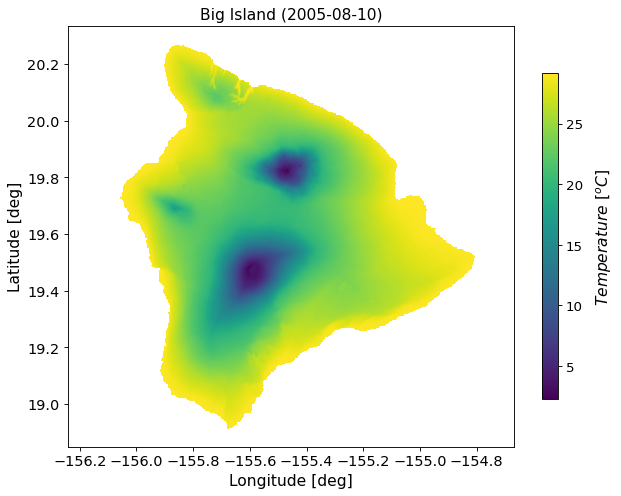

In [34]:
fig = pyplot.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot(1,1,1)

fp = r'test.tiff'

raster_img = rasterio.open(fp)

myarray = raster_img.read(1)
msk = raster_img.read_masks(1)

msk[msk>0] = 1
image = myarray * msk

img = ax.imshow(image, cmap='viridis')
show(raster_img, ax = ax, cmap='viridis')

cbar = fig.colorbar(img, ax=ax, shrink=0.6)

cbar.set_label(r'$Temperature \/\/ [^oC]$', rotation=90, fontsize= 14, labelpad=10)
cbar.ax.tick_params(labelsize=12) 

# set_axes(ax, (21.2, 21.7), (-158.3, -157.))

ax.set_xlabel("Longitude [deg]", fontsize = 14)
ax.set_ylabel("Latitude [deg]", fontsize = 14)
# ax.set_title("Big Island (LAI - 250 m)", fontsize=16)

fontsize = 13

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
        
ax.set_title(G_islandName(iCode)+" ("+date_str+")", fontsize=14)


fig.savefig('test2.png', dpi=200) 

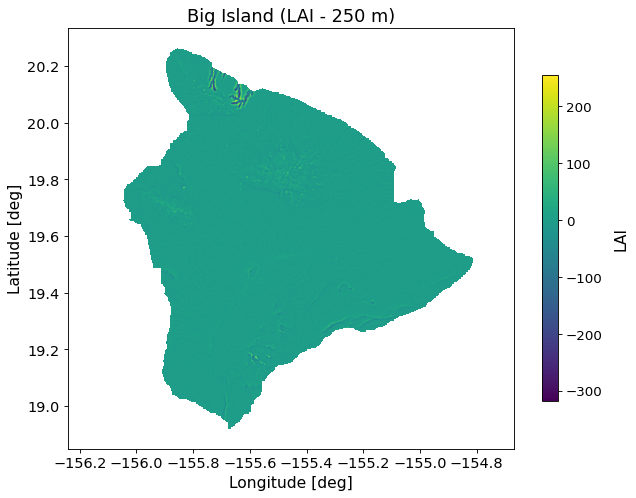

In [35]:
fig = pyplot.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot(1,1,1)

fp = r'./geoTiffs_250m/tpi/bi_tpi_250m.tif'

raster_img = rasterio.open(fp)

myarray = raster_img.read(1)
msk = raster_img.read_masks(1)

msk[msk>0] = 1
image = myarray * msk

img = ax.imshow(image, cmap='viridis')
show(raster_img, ax = ax, cmap='viridis')

cbar = fig.colorbar(img, ax=ax, shrink=0.6)

cbar.set_label('LAI', rotation=90, fontsize= 14, labelpad=10)
cbar.ax.tick_params(labelsize=12) 

# set_axes(ax, (21.2, 21.7), (-158.3, -157.))

ax.set_xlabel("Longitude [deg]", fontsize = 14)
ax.set_ylabel("Latitude [deg]", fontsize = 14)
ax.set_title("Big Island (LAI - 250 m)", fontsize=16)

fontsize = 13

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 

In [36]:
img = image # raster_img.read(1)
np.min(img), np.max(img)

(-318.91107, 254.67155)

In [37]:
msk[msk>0] = 1
np.min(msk), np.max(msk)

(0, 1)

In [38]:
pr = pd.read_csv("tmax_predictors.csv", encoding = "ISO-8859-1", engine='python')

pr = pr.set_index("SKN")
pr = pr[(pr.Island.isin(['MA', 'KO', 'MO', 'LA']))]

print(len(pr))

pr.head(5)

54


,Island,albedo,coastDist,dem_250,lai,rf,tpi,windSpeed,LON,LAT,optional
SKN,,,,,,,,,,,
249.1,MA,11.247000,970.460327,28.987511,0.650120,371.260681,-2.449152,2.305186,-156.438849,20.642089,True
253.0,MA,15.175417,6974.857422,1142.119385,0.537577,733.613464,-21.756172,1.551066,-156.342056,20.644222,True
258.6,MA,12.978750,468.906982,18.382671,0.747965,2087.510010,NaN,3.122898,-156.042480,20.662925,True
266.0,MA,15.175417,6725.787598,1319.686890,0.769055,2258.950928,-37.395905,3.594377,-156.151944,20.684167,True
267.0,MA,13.556167,9405.871094,932.056641,0.703230,800.120422,-2.219152,0.884056,-156.355519,20.700140,True


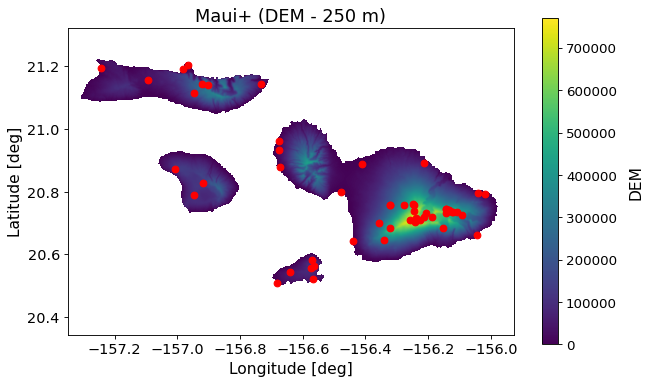

In [39]:
fig = pyplot.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot(1,1,1)

fp = r'./geoTiffs_250m/dem/mn_dem_250m.tif'

raster_img = rasterio.open(fp)

myarray = raster_img.read(1)
msk = raster_img.read_masks(1)

image = myarray * msk

image[image==0] = np.nan

# img = ax.imshow(image, cmap='viridis')
# show(raster_img, ax = ax, cmap='viridis')

import matplotlib.cm as cm
current_cmap = cm.get_cmap()
current_cmap.set_bad(color='white')

ds = gdal.Open(fp)
gt = ds.GetGeoTransform()     
extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],gt[3] + ds.RasterYSize * gt[5], gt[3])
img = ax.imshow(image, extent=extent, origin='upper', cmap='viridis')



cbar = fig.colorbar(img, ax=ax, shrink=0.6)

cbar.set_label('DEM', rotation=90, fontsize= 14, labelpad=10)
cbar.ax.tick_params(labelsize=12) 

# set_axes(ax, (21.2, 21.7), (-158.3, -157.))

ax.set_xlabel("Longitude [deg]", fontsize = 14)
ax.set_ylabel("Latitude [deg]", fontsize = 14)
ax.set_title("Maui+ (DEM - 250 m)", fontsize=16)

fontsize = 13

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
        
        
ax.scatter(pr.LON, pr.LAT, color='red')

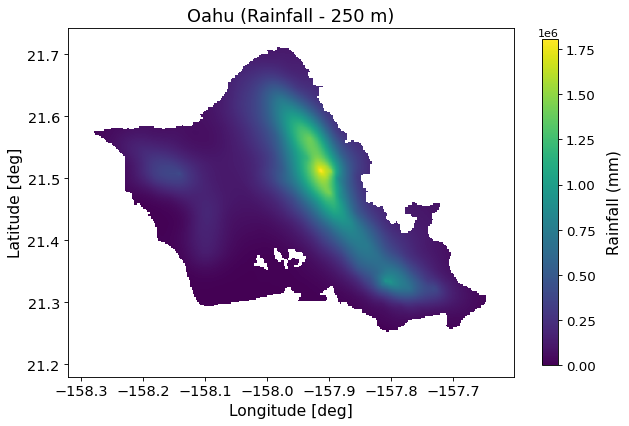

In [40]:
fig = pyplot.figure(figsize=(9,9), dpi=80)
ax = fig.add_subplot(1,1,1)

fp = r'./geoTiffs_250m/rf/oa_meanAnn_250m.tif'

raster_img = rasterio.open(fp)

myarray = raster_img.read(1)
msk = raster_img.read_masks(1)

image = myarray * msk

img = ax.imshow(image, cmap='viridis')
show(raster_img, ax = ax, cmap='viridis')

cbar = fig.colorbar(img, ax=ax, shrink=0.6)

cbar.set_label('Rainfall (mm)', rotation=90, fontsize= 14, labelpad=10)
cbar.ax.tick_params(labelsize=12) 

# set_axes(ax, (21.2, 21.7), (-158.3, -157.))

ax.set_xlabel("Longitude [deg]", fontsize = 14)
ax.set_ylabel("Latitude [deg]", fontsize = 14)
ax.set_title("Oahu (Rainfall - 250 m)", fontsize=16)

fontsize = 13

for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 
for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(fontsize) 

In [41]:
### How to install
### pip install --global-option=build_ext --global-option="-I/usr/include/gdal" GDAL==`gdal-config --version`    

from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

try:
    from osgeo import gdal
except ImportError:
    import gdal

gtif = gdal.Open(fp)
print(gtif.GetMetadata())

{'AREA_OR_POINT': 'Area'}


In [42]:
ds = gdal.Open(fp)

width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

In [43]:
width, height

(320, 250)

In [44]:
minx, maxx

(-158.322, -157.602)

In [45]:
gt

(-158.322, 0.0022499999999999964, 0.0, 21.742499999999996, 0.0, -0.00225)

In [46]:
## Use the command line sutax to see geoTif info
## gdalinfo bi_mask.tif

In [47]:
print(minx, miny, maxx, maxy)

-158.322 21.179999999999996 -157.602 21.742499999999996


In [48]:
gt

(-158.322, 0.0022499999999999964, 0.0, 21.742499999999996, 0.0, -0.00225)

In [49]:
import os
import gdal

ds = gdal.Open(fp)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
arr_min = arr.min()
arr_max = arr.max()
arr_mean = float(arr.mean())
arr_out = np.where((arr < arr_mean), 100000, arr)
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("test2.tiff", rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

/home/ehsan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


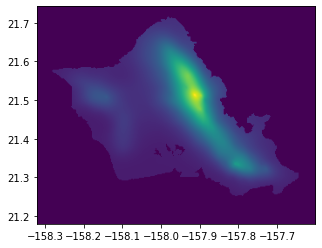

In [50]:
img = rasterio.open('test2.tiff')
show(img)